based on [this](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)

# 1. Load the packages

In [4]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import stopwordsiso

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

C:\Users\WaineJunior\AppData\Local\pypoetry\Cache\virtualenvs\csb-51-kpNpTjmy-py3.8\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


# 2. Import Newsgroups Text Data

In [6]:
# Import Dataset
df = pd.read_csv('./all_together.csv')
df.head()

,label,file,link,category,emotiveness,errors,pausatility,text,tokens,words in upper case,average sentence length,nouns,verbs,adverbs,adjectives,pronouns,date
0,fake,1.txt,ceticismopolitico.com,politica,0.263158,0.000000,2.000000,"katia abreu diz vai colocar expulsao moldura, ...",211.0,6.0,14.23080,46.0,30.0,13.0,7.0,26.0,2017-11-30
1,fake,10.txt,ceticismopolitico.com,politica,0.241667,0.007874,2.500000,"dr. ray peita bolsonaro, chama-o conservador f...",289.0,0.0,18.14290,64.0,56.0,18.0,11.0,20.0,2017-11-24
2,fake,100.txt,afolhabrasil.com.br,politica,0.127820,0.003636,1.812500,reinaldo azevedo desmascarado policia federal....,304.0,0.0,17.18750,88.0,45.0,8.0,9.0,18.0,2017-05-23
3,fake,1000.txt,diariodobrasil.org,politica,0.229008,0.001748,2.680000,relatorio assustador bndes mostra dinheiro pub...,639.0,14.0,22.88000,175.0,87.0,21.0,39.0,34.0,2017-07-24
4,fake,1001.txt,diariodobrasil.org,politica,0.269231,0.000000,0.894737,"radialista americano fala sobre pt: ""eles vend...",128.0,1.0,5.84211,31.0,21.0,8.0,6.0,12.0,2017-07-25


In [7]:
data = df["text"]
data

0       katia abreu diz vai colocar expulsao moldura, ...
1       dr. ray peita bolsonaro, chama-o conservador f...
2       reinaldo azevedo desmascarado policia federal....
3       relatorio assustador bndes mostra dinheiro pub...
4       radialista americano fala sobre pt: "eles vend...
                              ...                        
7195    para jornal britanico, acao contra lula lava j...
7196    temer diz acionou pf cade investigar aumentos ...
7197    os obstaculos politicos temer 2017. especialis...
7198    sexta-feira, 15 setembro 2017. boa noite! aqui...
7199    'nao envolvo politica', diz brasileiro preso v...
Name: text, Length: 7200, dtype: object

# 3. Tokenize and Clean-up using gensim’s simple_preprocess()

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  

data_words = list(sent_to_words(data))
data_words[0]

['katia',
 'abreu',
 'diz',
 'vai',
 'colocar',
 'expulsao',
 'moldura',
 'reclamar',
 'senadora',
 'katia',
 'abreu',
 'sem',
 'partido',
 'to',
 'disse',
 'expulsao',
 'pmdb',
 'resultado',
 'acao',
 'cupula',
 'atual',
 'legenda',
 'que',
 'segundo',
 'ela',
 'oportunista',
 'amanha',
 'vou',
 'botar',
 'moldura',
 'dourada',
 'expulsao',
 'porque',
 'maos',
 'onde',
 'veio',
 'atestado',
 'boa',
 'conduta',
 'curriculo',
 'essas',
 'pessoas',
 'expulsaram',
 'servem',
 'pais',
 'eles',
 'servem',
 'pais',
 'beneficios',
 'proprios',
 'disse',
 'katia',
 'abreu',
 'ue',
 'expulsao',
 'algo',
 'tao',
 'bom',
 'curriculo',
 'tanta',
 'choradeira',
 'katia',
 'sabemos',
 'motivo',
 'provavelmente',
 'katia',
 'valor',
 'pt',
 'partido',
 'deveria',
 'te',
 'la',
 'absorvido',
 'ao',
 'parece',
 'pt',
 'gostava',
 'katia',
 'somente',
 'ficasse',
 'entrincheirada',
 'dentro',
 'pmdb',
 'ou',
 'seja',
 'rebaixar',
 'demais',
 'resta',
 'katia',
 'ficar',
 'chorando',
 'pitangas',
 'todos

# 4. Lemmatization

Lemmatization is a process where we convert words to its root word.

For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.

The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.

## If you're unable to run the cell below, make sure you have pt_core_news_sm from spacy.

### To download it, run `python -m spacy download pt_core_news_sm`

In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'pt_core_news_sm' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download pt_core_news_sm
nlp = spacy.load('pt_core_news_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized[0]


'katia abreu dizer colocar expulsao moldurar reclamar abreu partir dizer expulsao pmdb resultar cupula atual legendar oportunista amanhar botar moldurar dourar expulsao maos vir atestar bom conduta curriculo pessoa expulsar servir pai servir pai beneficios proprios dizer katia abreu expulsao bom curriculo tanto choradeira katia saber motivar provavelmente katia valor pt partir dever absorver parecer gostar katia somente ficar entrincheirar dentro pmdb rebaixar demais restar katia ficar chorar pitanga canto momento cadastrar abreu fileira situacao patetica ministro agricultura'

## Remove stopwords

In [19]:
stops = set(stopwordsiso.stopwords("pt"))
def remove_stopwords(text: str) -> str:
    # print(text)
    return " ".join([t for t in text.split(" ") if t not in stops])

data_no_stopwords = [remove_stopwords(text) for text in data_lemmatized]
data_no_stopwords[0]

7200


'katia abreu colocar expulsao moldurar reclamar abreu expulsao pmdb resultar cupula atual legendar oportunista amanhar botar moldurar dourar expulsao maos vir atestar conduta curriculo pessoa expulsar servir pai servir pai beneficios proprios katia abreu expulsao curriculo choradeira katia motivar provavelmente katia pt dever absorver parecer gostar katia ficar entrincheirar pmdb rebaixar restar katia ficar chorar pitanga canto cadastrar abreu fileira situacao patetica ministro agricultura'

# 5. Create the Document-Word matrix

The LDA topic model algorithm requires a document word matrix as the main input.

You can create one using CountVectorizer. 

We configured the CountVectorizer to consider words that has occurred at least 10 times (min_df), remove built-in portuguese stopwords, convert all words to lowercase, and a word can contain numbers and alphabets of at least length 2 in order to be qualified as a word.

So, to create the doc-word matrix, you need to first initialise the CountVectorizer class with the required configuration and then apply fit_transform to actually create the matrix.

Since most cells contain zeros, the result will be in the form of a sparse matrix to save memory.

If you want to materialize it in a 2D array format, call the todense() method of the sparse matrix like its done in the next step.

In [24]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             #  stop_words='portuguese',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{2,}',  # num chars > 2
                             # max_features=50000,             # max number of uniq words
                            )
data_vectorized = vectorizer.fit_transform(data_no_stopwords)

# 6. Check Sparsicity

Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, we am interested in knowing what percentage of cells contain non-zero values.

In [26]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print(f"Sparsicity: {((data_dense > 0).sum()/data_dense.size)*100} %")

Sparsicity: 1.5491449876351227 %


# 7. Build LDA model with sklearn

Everything is ready to build a Latent Dirichlet Allocation (LDA) model. Let’s initialise one and call fit_transform() to build the LDA model.

For this example, we have set the n_components based on prior knowledge about the dataset. Later we will find the optimal number using grid search.

In [32]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=30,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = None,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

lda_model  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=30,
                          random_state=100)

# 8. Diagnose model performance with perplexity and log-likelihood

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [29]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -14274461.753710931
Perplexity:  2375.125130842241
{'batch_size': 256,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 40,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


# 9. How to GridSearch the best LDA model?

The most important tuning parameter for LDA models is n_components (number of topics). In addition, we are going to search learning_decay (which controls the learning rate) as well.

Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter. These could be worth experimenting if you have enough computing resources.

Be warned, the grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, this process can consume a lot of time and resources.

In [49]:
_filename_model = "model_lda.obj"
import pickle, os

def load_model():
    if os.path.exists(_filename_model):
        with open(_filename_model, "rb") as f:
            return pickle.load(f)
    return None

def save_model(model):
    with open(_filename_model, "wb") as f:
        pickle.dump(model, f)

In [52]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25], 
    'learning_decay': [.7, .8], 
    "learning_method": ['online']}

# Init the Model
lda = LatentDirichletAllocation()

_model = load_model()
if(_model is None):
    # Init Grid Search Class
    _model = GridSearchCV(lda, param_grid=search_params)
    # Do the Grid Search
    _model.fit(data_vectorized)
    save_model(_model)

In [54]:
model = load_model()

# 10. How to see the best topic model and its parameters?

In [58]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.8, 'learning_method': 'online', 'n_components': 10}
Best Log Likelihood Score:  -2969292.199259298
Model Perplexity:  2332.458774617689


# 11. Compare LDA Model Performance Scores

In [68]:
model.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_decay', 'param_learning_method', 'param_n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

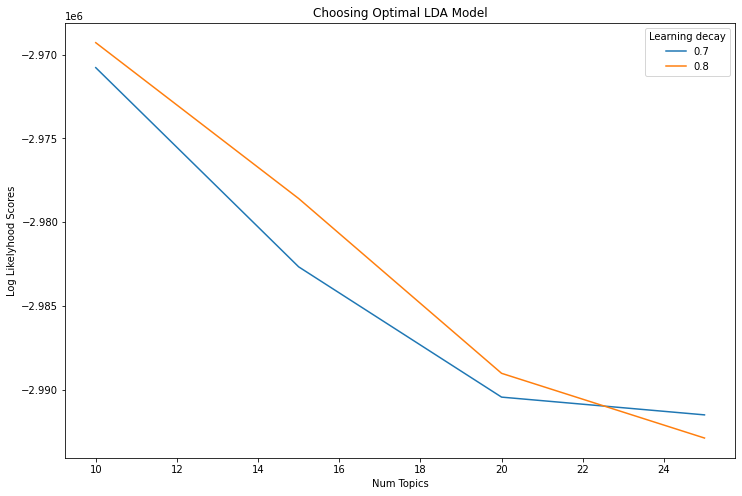

In [71]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25]
# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_["params"] if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_["mean_test_score"][i]) for i, learning_decay in enumerate(model.cv_results_["param_learning_decay"]) if learning_decay==0.7]
log_likelyhoods_8 = [round(model.cv_results_["mean_test_score"][i]) for i, learning_decay in enumerate(model.cv_results_["param_learning_decay"]) if learning_decay ==0.8]

# Show graph
plt.figure(figsize=(12, 8))
# plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_8, label='0.8')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

# 12. How to see the dominant topic in each document?

To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In the table below, we’ve greened out all major topics in a document and assigned the most dominant topic in its own column.

In [73]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = [f"Topic {i}" for i in range(best_lda_model.n_components)]

# index names
docnames = [f"Doc {i}" for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,dominant_topic
Doc 0,0.230000,0.000000,0.000000,0.160000,0.000000,0.080000,0.000000,0.320000,0.200000,0.000000,7
Doc 1,0.350000,0.180000,0.000000,0.000000,0.280000,0.000000,0.000000,0.190000,0.000000,0.000000,0
Doc 2,0.050000,0.000000,0.000000,0.170000,0.000000,0.130000,0.000000,0.000000,0.130000,0.520000,9
Doc 3,0.000000,0.000000,0.000000,0.030000,0.530000,0.000000,0.000000,0.360000,0.000000,0.080000,4
Doc 4,0.350000,0.120000,0.470000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,2
Doc 5,0.000000,0.000000,0.000000,0.000000,0.000000,0.240000,0.000000,0.000000,0.740000,0.000000,8
Doc 6,0.000000,0.000000,0.000000,0.000000,0.120000,0.500000,0.080000,0.000000,0.290000,0.000000,5
Doc 7,0.270000,0.080000,0.000000,0.430000,0.000000,0.060000,0.000000,0.000000,0.000000,0.150000,3
Doc 8,0.740000,0.000000,0.000000,0.060000,0.000000,0.060000,0.000000,0.000000,0.000000,0.110000,0
Doc 9,0.100000,0.000000,0.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,9


# 13. Review topics distribution across documents

In [74]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,1476
1,9,1429
2,0,1263
3,1,899
4,7,680
5,6,640
6,5,265
7,2,250
8,8,188
9,4,110


# 14. How to visualize the LDA model with pyLDAvis?

The pyLDAvis offers the best visualization to view the topics-keywords distribution.

A good topic model will have non-overlapping, fairly big sized blobs for each topic.

In [75]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\WaineJunior\AppData\Local\pypoetry\Cache\virtualenvs\csb-51-kpNpTjmy-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\WaineJunior\AppData\Local\pypoetry\Cache\virtualenvs\csb-51-kpNpTjmy-py3.8\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\WaineJunior\AppData\Local\pypoetry\Cache\virtualenvs\csb-51-kpNpTjmy-py3.8\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\WaineJunior\AppData\Local\pypoetry\Cache\virtualenvs\csb-51-kpNpTjmy-py3.8\lib\site-packa

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      32.420952   8.115230       1        1  18.960117
0       0.648955  71.707100       2        1  18.440748
3      71.019684   9.971006       3        1  14.724871
7       3.785981  33.185135       4        1  10.851133
1     -42.666500  -9.222070       5        1  10.594054
6      -3.621689 -43.526516       6        1   7.820086
2      -3.632402  -4.171708       7        1   6.269912
4     -36.584400  35.804413       8        1   5.189498
5      44.391380  50.615383       9        1   3.584225
8      40.235809 -31.591665      10        1   3.565356, topic_info=            Term          Freq         Total Category  logprob  loglift
9554       temer   8373.000000   8373.000000  Default  30.0000  30.0000
7841  presidente  17326.000000  17326.000000  Default  29.0000  29.0000
7643    policiar   5787.000000   5787.000000  Default  28.0000  28.0000
3611    empresar   5043.000000   5043.000000  Default  27.0000  27.0000
2878     deputar   4957.000000   4957.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
8323     receber    415.188750   4381.560359  Topic10  -5.0607   0.9775
2590       crime    398.672363   3773.867954  Topic10  -5.1013   1.0862
7372       pedir    417.755720   6639.422116  Topic10  -5.0545   0.5680
3648   encontrar    353.248287   2897.693820  Topic10  -5.2223   1.2294
1677       casar    371.727616   7446.301540  Topic10  -5.1713   0.3366

[804 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
8          1  0.019846  abastecimento
8          4  0.972474  abastecimento
24         2  0.177298        abortar
24         8  0.817990        abortar
41         1  0.990716     absolvicao
...      ...       ...            ...
10283      7  0.996512           zika
10285      2  0.001648          zonar
10285      4  0.113724          zonar
10285      5  0.702122          zonar
10285      6  0.181299          zonar

[2539 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 4, 8, 2, 7, 3, 5, 6, 9])

# 15. How to see the Topic’s keywords?

The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.

In [76]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

C:\Users\WaineJunior\AppData\Local\pypoetry\Cache\virtualenvs\csb-51-kpNpTjmy-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abafar,abaixar,abalar,abandonar,abar,abarcar,abastecer,abastecido,abastecimento,abater,...,zelar,zelote,zerar,zeze,zika,zombar,zonar,zoologico,zuckerberg,zveiter
Topic 0,0.100241,132.348256,44.642831,94.749299,0.100091,6.332119,0.100153,0.100079,0.100075,0.100104,...,0.100236,0.114066,28.538169,0.100453,0.123228,4.902130,0.766727,0.100077,15.310439,0.100114
Topic 1,0.100256,300.684498,19.372983,266.979035,0.100104,0.101078,13.318664,0.100049,0.100205,50.988288,...,16.355380,0.100301,0.100072,0.100165,0.100070,17.758607,469.566310,17.322696,0.100056,0.100047
Topic 2,0.100094,36.208153,0.100125,0.120506,0.100063,0.100473,0.100272,0.100059,0.100174,0.100072,...,0.100084,0.100095,0.100129,0.100977,154.330215,0.100509,0.100465,0.100064,0.100079,0.100871
Topic 3,0.102357,352.592866,24.828314,12.578713,0.100071,0.109216,0.104275,0.101028,0.100162,8.430651,...,0.100364,0.106041,0.100456,7.120043,0.100191,0.100485,0.100287,0.100038,0.100043,31.437956
Topic 4,0.100235,76.435258,0.100058,7.727633,0.100087,8.448982,25.437919,0.100057,0.100241,0.100095,...,0.100087,0.100043,0.100083,0.100050,0.100077,0.100052,0.100183,0.100053,0.100065,0.101363


# 16. Get the top 15 keywords each topic

From the above output, we want to see the top 15 keywords that are representative of the topic.

The show_topics() defined below creates that.

In [77]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\WaineJunior\AppData\Local\pypoetry\Cache\virtualenvs\csb-51-kpNpTjmy-py3.8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,pessoa,pai,politicar,vidar,querer,passar,formar,brasileiro,mundo,ficar,direito,social,achar,casar,historiar
Topic 1,militar,casar,pessoa,publicar,ficar,pai,policiar,gente,acontecer,video,passar,querer,contar,deixar,armar
Topic 2,cidade,policiar,rir,janeiro,pessoa,saude,morto,governar,escola,morte,prefeitura,feirar,tres,publicar,estadual
Topic 3,presidente,temer,deputar,governar,ministrar,camara,senador,pmdb,senado,politicar,afirmar,votar,parlamentar,psdb,dilma
Topic 4,aumentar,mercar,empresar,produto,resultar,aguar,saude,brasileiro,medir,programar,analisar,lei,paises,reduzir,problema
Topic 5,falar,globo,jornalista,musicar,artista,filmar,cantor,show,amigo,tv,cinema,domingo,ficar,contar,passar
Topic 6,coreia,norte,trump,americano,nuclear,pai,armar,guerra,presidente,coreano,sul,militar,forcar,atacar,paises
Topic 7,empresar,milhoes,dinheiro,odebrecht,contar,receber,pagamento,propinar,campanha,pagar,comprar,afirmar,obrar,acordar,publicar
Topic 8,policiar,apo,preso,hospital,familia,medicar,informar,filho,mulher,feirar,vitimar,ficar,presar,afirmar,acordar
Topic 9,presidente,federal,lavar,jato,pedir,defeso,juiz,publicar,advogar,processar,prisao,operacao,justica,denunciar,afirmar


# 17. How to cluster documents that share similar topics and plot?

We can use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object. Since out best model has N clusters, I’ve set n_clusters=N in KMeans().

Alternately, you could avoid k-means and instead, assign the cluster as the topic column number with the highest probability score.

We now have the cluster number. But we also need the X and Y columns to draw the plot.

For the X and Y, you can use SVD on the lda_output object with n_components as 2. SVD ensures that these two columns captures the maximum possible amount of information from lda_output in the first 2 components.

In [78]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.35  0.27  0.1   0.55  0.08  0.1   0.13  0.26  0.08  0.62]
 [-0.49 -0.34 -0.1  -0.21 -0.08 -0.13 -0.31  0.12 -0.04  0.67]]
Perc of Variance Explained: 
 [0.06 0.24]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

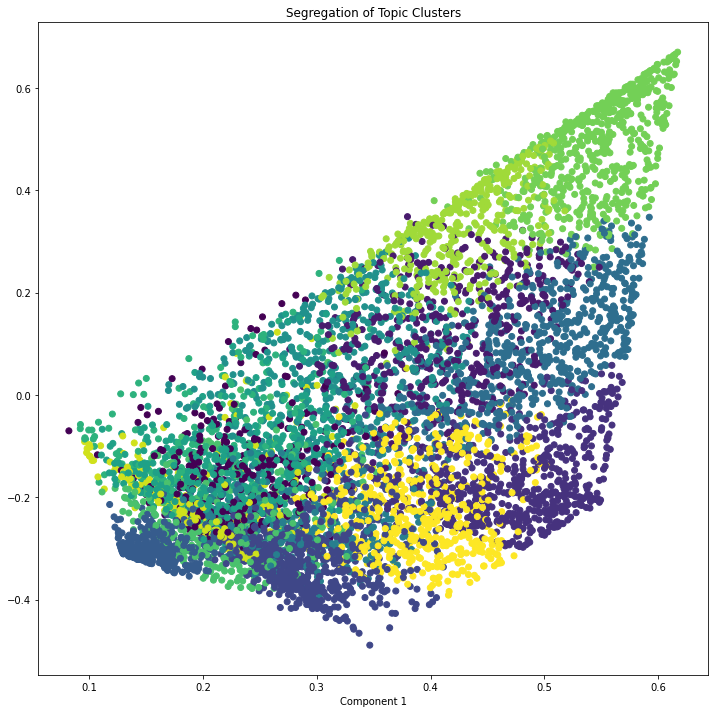

In [79]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )